# Face recognition using neural network features

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

In [1]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation, Input, Dropout, Activation, BatchNormalization
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import backend as K

Using TensorFlow backend.


In [2]:
import h5py
from keras.models import load_model

In [3]:
import tensorflow as tf
import gc
from keras.utils.generic_utils import get_custom_objects

In [4]:
#!pip install opencv-python

In [5]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from copy import copy
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


In [242]:
from skimage import transform
from skimage.feature import peak_local_max
from skimage.io import imshow
from skimage.color import gray2rgb, rgb2gray
from scipy import ndimage

First of all, you have you have to read the data. Run the cell below to unpack data.

In [7]:
from get_data import unpack
unpack('Face_Recognition_data.zip')

In [8]:
from scores import iou_score

### Reading data for image and video classification (1 point)

Implement function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recofnition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [9]:
def load_images(data_type, x, y, dir_name):
    data = pd.read_csv(dir_name + "/{}/y_{}.csv".format(data_type, data_type))
    for index, row in data.iterrows():
        image_name = row["filename"]
        path = dir_name + "/{}/images/".format(data_type) + image_name
        image = cv2.imread( path ).astype(np.float32)  / 255.
        x[image_name] = cv2.cvtColor( image, cv2.COLOR_BGR2RGB)
        y[image_name] = row["class_id"]

In [10]:
def load_videos(data_type, x, y, dir_name):
    data = pd.read_csv(dir_name + "/{}/y_{}.csv".format(data_type, data_type))
    for index, row in data.iterrows():
        video_name = row["filename"]
        path = dir_name + "/{}/videos/".format(data_type) + str(video_name)        
        x[str(video_name)] = [ cv2.cvtColor( cv2.imread( path + "/" + frame ).astype(np.float32)  / 255., cv2.COLOR_BGR2RGB) for frame in os.listdir(path) ]            
        y[str(video_name)] = row["class_id"]

In [11]:
def load_image_data(dir_name = 'Face_Recognition_data/image_classification'):
    x_train, y_train, x_test, y_test = {}, {}, {}, {}
    
    load_images("train", x_train, y_train, dir_name)
    load_images("test", x_test, y_test, dir_name)
    
    return x_train, y_train, x_test, y_test

In [12]:
x_train, y_train, x_test, y_test = load_image_data()
print( len(x_train), '\ttraining images')
print( len(x_test), '\ttesting images')

661 	training images
808 	testing images


In [13]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for index, key in enumerate(np.random.choice([key for key in data], size = n_cols*n_rows)):
        plt.subplot(n_rows, n_cols, index+1)
        plt.axis('off')
        plt.imshow(function([data[key]]))
        plt.title(labels[key])
    plt.show()

That is how the data looks like.

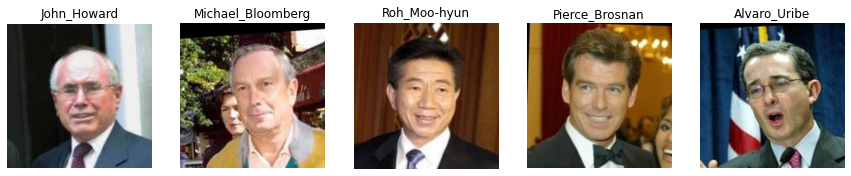

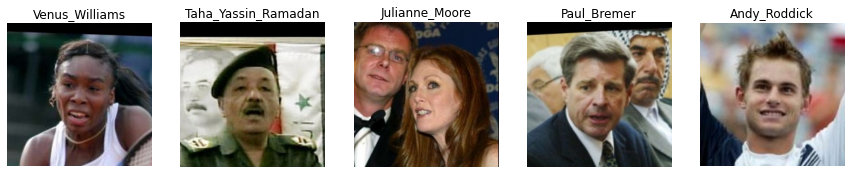

In [14]:
visualize(x_train, y_train)
visualize(x_test, y_test)

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [15]:
def load_video_data(dir_name = 'Face_Recognition_data/video_classification'):
    x_train, y_train, x_test, y_test = {}, {}, {}, {}    
    load_images("train", x_train, y_train, dir_name)
    load_videos("test", x_test, y_test, dir_name)    
    return x_train, y_train, x_test, y_test

In [16]:
video_train, train_labels, video_test, test_labels = load_video_data()
print( len(video_train), '\ttraining images' )
print( len(video_test), '\ttesting videos' )

729 	training images
70 	testing videos


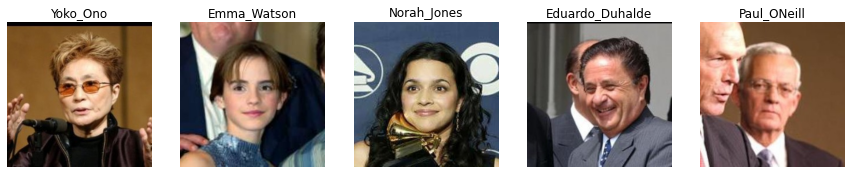

In [17]:
visualize(video_train, train_labels)

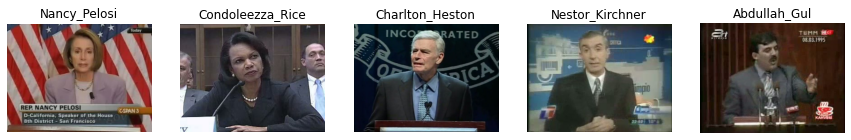

In [18]:
visualize({i:video_test[i][1] for i in video_test}, test_labels)

In [652]:
def visualize_points(img, points):
    imshow(img)
    for i in range(14):        
        x, y = (points[2*i] + .5 )*KEYPOINTS_INPUT_SHAPE[0], (points[2*i + 1] + .5 )*KEYPOINTS_INPUT_SHAPE[1]
        plt.scatter(x, y, s=20, c='r')

In [653]:
def visualize_nose_mouth_points(img, points):
    imshow(img)
    for i in [ 10, 12 ]:
        x, y = (points[2*i] + .5 )*KEYPOINTS_INPUT_SHAPE[0], (points[2*i + 1] + .5 )*KEYPOINTS_INPUT_SHAPE[1]
        plt.scatter(x, y, s=20, c='r')

In [654]:
def visualize_keypoints(images, points_list, folder, model_id):
    images = np.array(images)
    figure = plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        plt.subplot(5, 5, i+1)
        image = images[i, :]
        points = points_list[i, :]
        visualize_points(image, points)
        plt.axis('off')
    #plt.show()
    
    if folder is not None and model_id is not None:
        with open('{}/{}.png'.format(folder, model_id), 'wb') as file:
            figure.savefig(file, bbox_inches='tight')
            plt.close(figure)

In [655]:
def visualize_nose_mouth(images, points_list, folder, model_id):
    images = np.array(images)
    figure = plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        plt.subplot(5, 5, i+1)
        image = images[i, :]
        points = points_list[i, :]
        visualize_nose_mouth_points(image, points)
        plt.axis('off')
    #plt.show()
    
    if folder is not None and model_id is not None:
        with open('{}/{}.png'.format(folder, model_id), 'wb') as file:
            figure.savefig(file, bbox_inches='tight')
            plt.close(figure)

In [656]:
def visualize_faces(images):
    images = np.array(images)
    figure = plt.figure(figsize=(20, 20))
    for i, image in enumerate(images):
        plt.subplot(5, 5, i+1)
        plt.imshow(image)
        plt.axis('off')
    #plt.show()

In [657]:
def visualize_heatmap(heatmaps, coordinates_list=None):
    plt.figure(figsize=(20, 20))
    for i, heatmap in enumerate(heatmaps):
        plt.subplot(5, 5, i+1)
        plt.imshow(heatmap)
        if coordinates_list is not None:
            for y, x in coordinates_list[i]:
                plt.scatter(x, y, s=20, c='r')
            y, x = np.mean( coordinates_list[i], axis=0 )
            plt.scatter(x, y, s=20, c='b')
        plt.axis('off')
    #plt.show()

### Preprocessing (3 points)
You have to implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).

For face detection and facial keypoint regression you can use your models from the previous tasks.

In [209]:
fcnn_model = load_model('fcnn_model_lenet4_full.h5')

C:\Users\MachineLearningUser\AppData\Local\conda\conda\envs\ml\lib\site-packages\keras\models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [210]:
def smooth_L1_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true, y_pred)

In [211]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [212]:
get_custom_objects().update({"smooth_L1_loss": smooth_L1_loss, "coeff_determination": coeff_determination})

In [27]:
test_images = [ x_test[key] for key in x_test ]

In [610]:
test_video_images = [ video_test[key][0] for key in video_test ]

In [658]:
FCNN_INPUT_SHAPE = (176, 176, 3)
KEYPOINTS_INPUT_SHAPE = (100, 100, 1)
RECOGNITION_INPUT_SHAPE = (224, 224, 3)

In [659]:
def correct_bbox(bbox, max_bound):
    if bbox[0] < 0 or np.isnan(bbox[0]): bbox[0] = 0
    if bbox[1] < 0 or np.isnan(bbox[1]): bbox[1] = 0
    if bbox[2] > max_bound[0] or np.isnan(bbox[2]): bbox[2] = max_bound[0]
    if bbox[3] > max_bound[1] or np.isnan(bbox[3]): bbox[3] = max_bound[1]

In [703]:
def crop_bottom(image, rate=0.25):
    border = int(round(image.shape[0] * rate ))
    image = image[ : -border, : ]            
    return image

In [736]:
def crop_to_square(image):
    size = np.min([ image.shape[0], image.shape[1] ])
    if image.shape[0] > size:
        border = int(round((image.shape[0] - size) / 2 ))
        image = image[ border : -border, :]    
    elif  image.shape[1] > size:
        border = int(round((image.shape[1] - size) / 2 ))
        image = image[ :, border : -border ]   
    #print(image.shape)
    return image

C:\Users\MachineLearningUser\AppData\Local\conda\conda\envs\ml\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


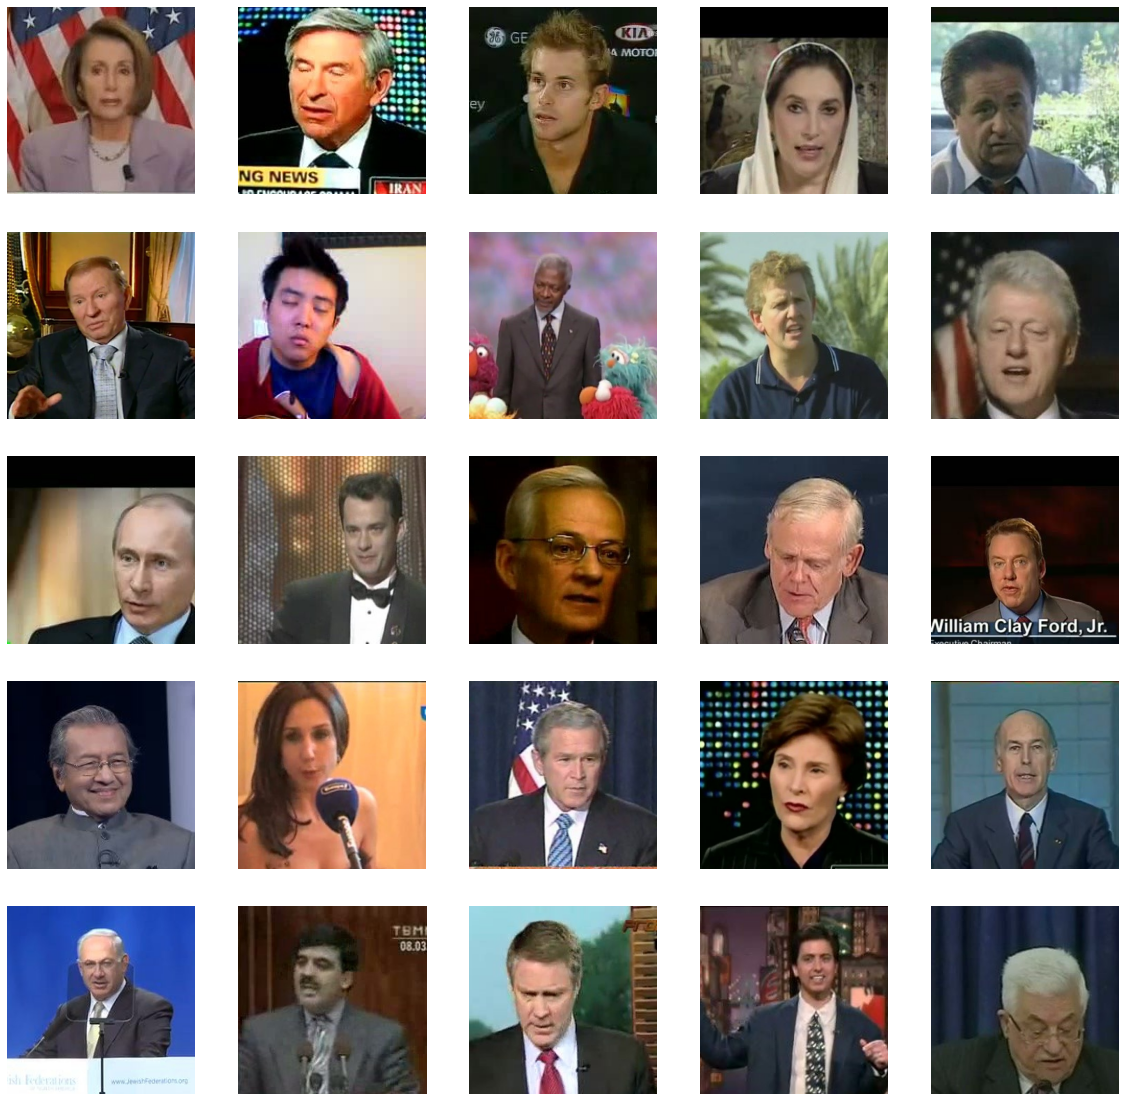

In [737]:
visualize_faces( [ crop_to_square( crop_bottom( img ) ) for img in test_video_images[:25] ] )

In [742]:
def get_bboxes(fcnn_model, images):
    
    """
    for images (not videos):
    min_distance_rate = 0.08
    exclude_border_rate = 0.25
    num_peaks = 5
    threshold_abs = 0.5
    radius_rate = 1.9 # 1.7 # 1.9 # 1.8
    vertical_shift_rate = 0.55 # 0.45 # 0.55 # 0.5
    max_radius_rate = 1.
    min_radius_rate = .63    
    """
    min_distance_rate = 0.1
    exclude_border_rate = 0.08
    num_peaks = 3
    threshold_abs = 0.5
    radius_rate = 1.9 # 1.7 # 1.9 # 1.8
    vertical_shift_rate = 0.55 # 0.45 # 0.55 # 0.5
    max_radius_rate = 1.
    min_radius_rate = .63
    default_radius_rate = 1.
    
    resized_images = np.array([ transform.resize( img, (FCNN_INPUT_SHAPE[0], FCNN_INPUT_SHAPE[1]), anti_aliasing=True) for img in images ])
    
    pred_bboxes = []
    predictions = fcnn_model.predict(resized_images) 
    map_shape = predictions[0].shape
    coordinates_list = []
    
    for image_index, original in enumerate(images):
        prediction = predictions[image_index][:,:,1]
        coordinates = peak_local_max(   prediction,
                                        min_distance = int(map_shape[0] * min_distance_rate),
                                        exclude_border = int(map_shape[0] * exclude_border_rate),
                                        num_peaks = num_peaks,
                                        threshold_abs = threshold_abs  )        
        coordinates_list.append( coordinates )
        
        center = np.mean( coordinates, axis=0 )
        
        radius = np.mean(np.linalg.norm(coordinates - center, axis=-1))
        
        max_radius = max_radius_rate * FCNN_INPUT_SHAPE[0] / map_shape[0]
        min_radius = min_radius_rate * FCNN_INPUT_SHAPE[0] / map_shape[0]
        default_radius = default_radius_rate * FCNN_INPUT_SHAPE[0] / map_shape[0]
        
        if radius < min_radius or radius > max_radius:
            radius = default_radius
            
        half_size = radius * radius_rate * FCNN_INPUT_SHAPE[0] / map_shape[0]
        vertical_shift = radius * vertical_shift_rate * FCNN_INPUT_SHAPE[0] / map_shape[0]
        
        center_y, center_x = center        
                
        candidate = [ center_y * FCNN_INPUT_SHAPE[0] / map_shape[0] - half_size + vertical_shift,
                      center_x * FCNN_INPUT_SHAPE[1] / map_shape[1] - half_size,
                      center_y * FCNN_INPUT_SHAPE[0] / map_shape[0] + half_size + vertical_shift,
                      center_x * FCNN_INPUT_SHAPE[1] / map_shape[1] + half_size]
        
        #print(candidate)
        correct_bbox(candidate, FCNN_INPUT_SHAPE)
        
        #print(candidate)
        pred_bboxes.append( [   
                              int(np.round(candidate[0] * original.shape[0] / FCNN_INPUT_SHAPE[0])),
                              int(np.round(candidate[1] * original.shape[1] / FCNN_INPUT_SHAPE[1])),
                              int(np.round(candidate[2] * original.shape[0] / FCNN_INPUT_SHAPE[0])),
                              int(np.round(candidate[3] * original.shape[1] / FCNN_INPUT_SHAPE[1]))
                            ])
        
    return pred_bboxes, predictions, coordinates_list

In [743]:
def get_facial_keypoints(facial_keypoints_regressor, images):
    resized_images = np.array([ transform.resize(rgb2gray(img), (KEYPOINTS_INPUT_SHAPE[0], KEYPOINTS_INPUT_SHAPE[1]), anti_aliasing=True) for img in images ])            
    resized_images = resized_images[:, :, :, None]
    points = facial_keypoints_regressor.predict(resized_images)
    return points, resized_images

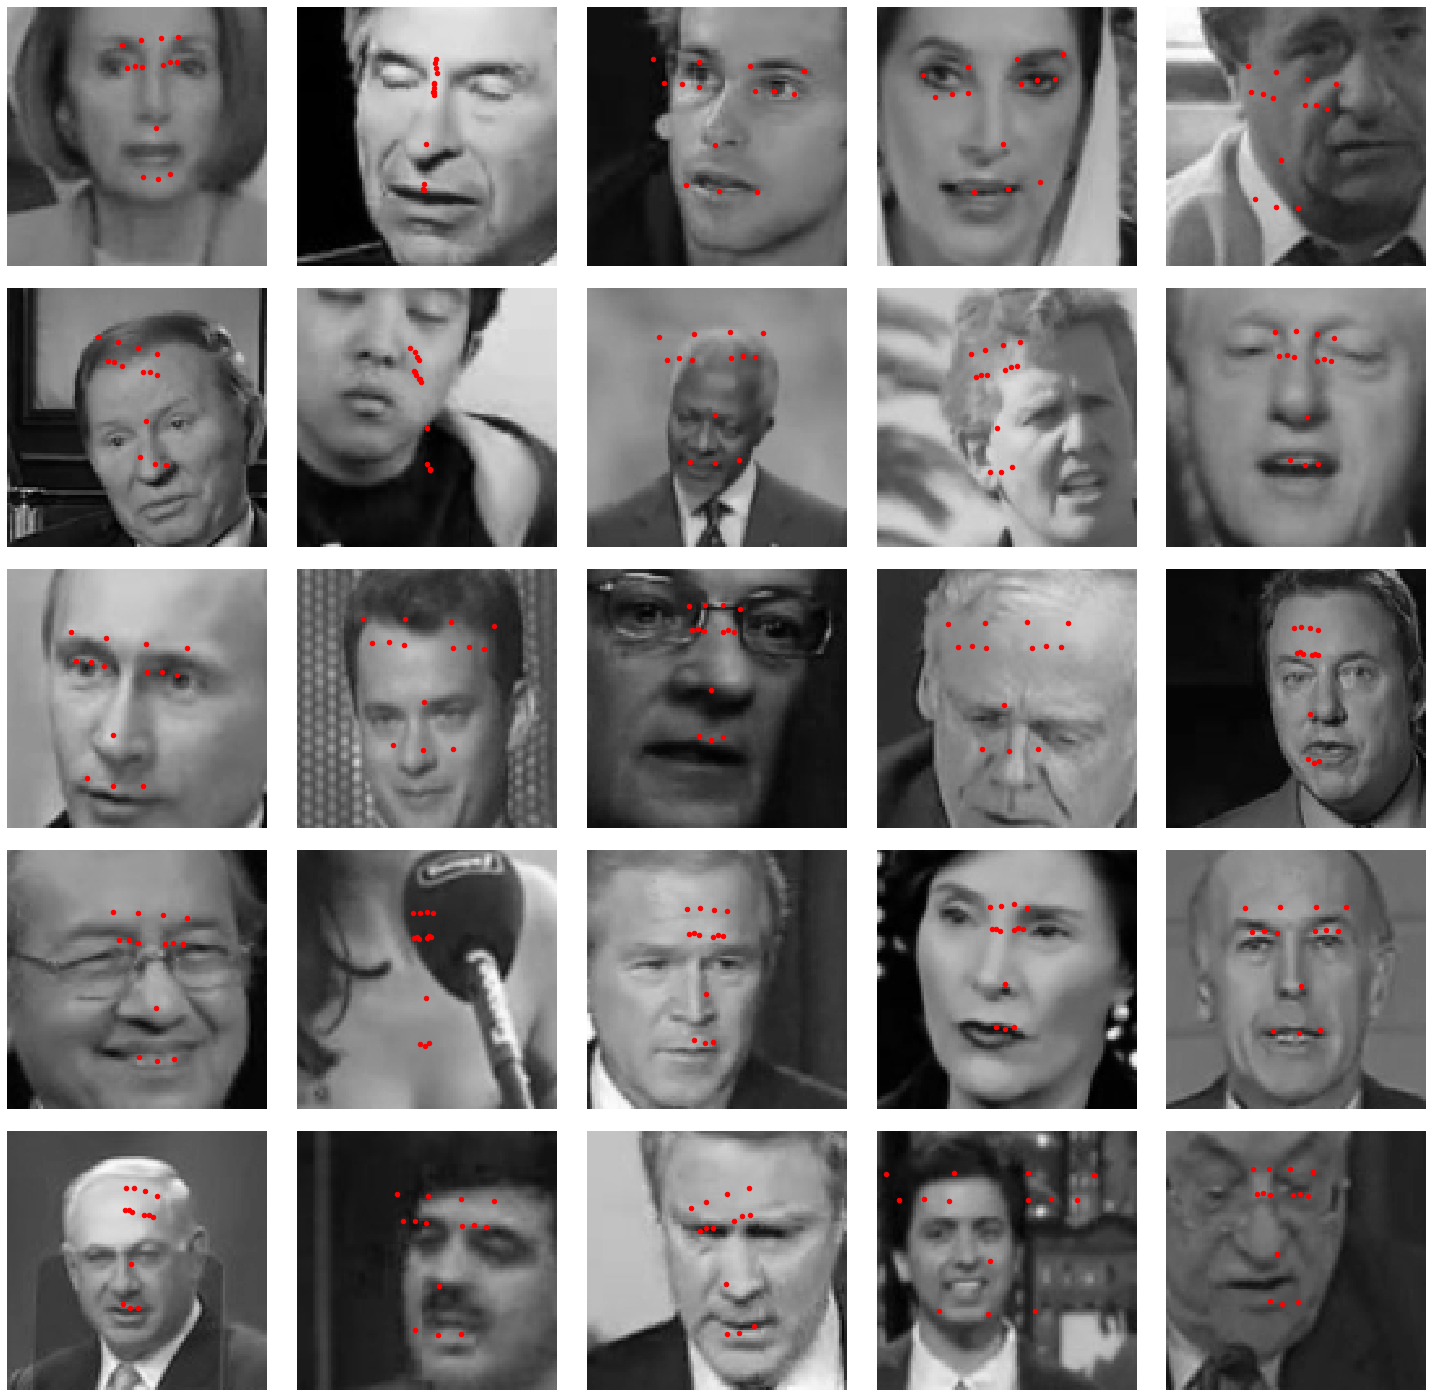

In [744]:
cropped_images = [ crop_to_square( crop_bottom( img ) ) for img in test_video_images[:25] ] 
pred_bboxes, predictions, coordinates_list = get_bboxes(fcnn_model, cropped_images)
face_images = [ cropped_images[i][bb[0]:bb[2], bb[1]:bb[3], :] for i, bb in enumerate(pred_bboxes) ]
#visualize_heatmap(predictions[:25, :, :, 1], coordinates_list)
#visualize_faces(face_images[:25])
points, face_images = get_facial_keypoints(facial_keypoints_regressor, face_images)
visualize_keypoints(face_images[:25], points[:25], None, None)

C:\Users\MachineLearningUser\AppData\Local\conda\conda\envs\ml\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


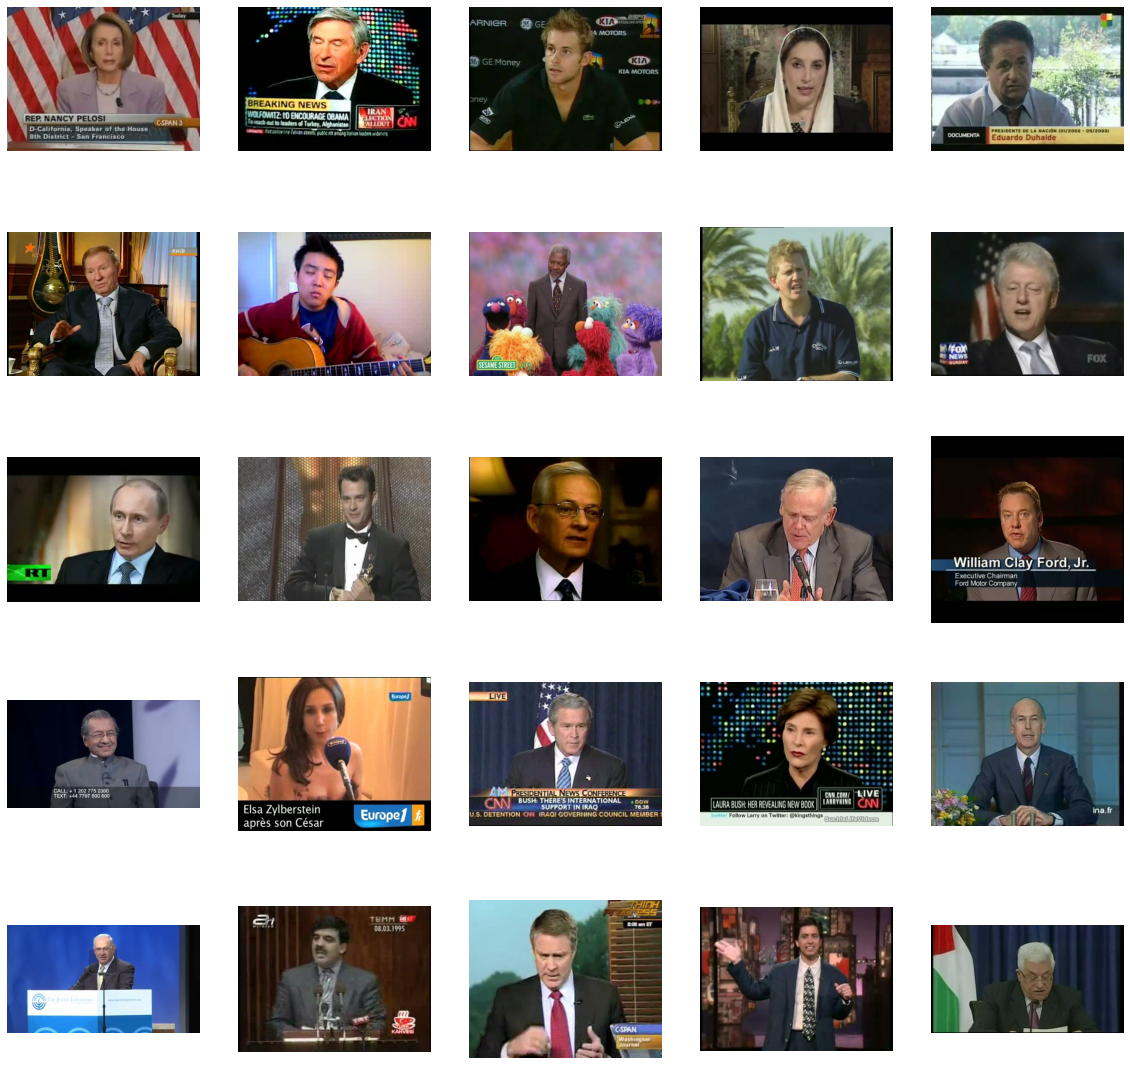

In [674]:
visualize_faces(test_video_images[:25])

In [ ]:
K.clear_session()
gc.collect()

for experiment_id in [ 1681, 1685, 1686, 1687, 1688, 1700, 1718, 1740, 1760, 1762, 1782, 1811, 1828, 1832, 1857, 1875, 1907, 1944, 1945, 1962, 1971, 1994, 2000, 2085, 2196, 2446, 2529, 2547, 2574, 2580, 2597, 2608, ]:
    print ("======= Experiment: {} =======".format(experiment_id))
    try:
        facial_keypoints_regressor = load_model('../../w2/facial-keypoints/models/facial_keypoints_regressor_{}.h5'.format(experiment_id))
        points, normalized_images = get_facial_keypoints(facial_keypoints_regressor, images)      
        visualize_keypoints(normalized_images[:25], points[:25], "keypoints_results_1.9_0.5", experiment_id)
        #visualize_heatmap(predictions[:25, :, :, 1], coordinates_list)
    except Exception as ex:
        print(ex)
        
    K.clear_session()
    gc.collect()

In [360]:
facial_keypoints_regressor = load_model('../../w2/facial-keypoints/models/facial_keypoints_regressor_1686.h5')

In [662]:
def rotate(image, angle, center):
    y = center[0].astype(np.uint16)
    x = center[1].astype(np.uint16)
    image = np.copy(np.pad(image, ((y, 0), (x, 0), (0, 0)), mode='constant', constant_values=0))    
    image = ndimage.rotate(image, angle, reshape=False)
    return image[ y :, x : ]

In [663]:
def rotate_cv2(image, angle, center):
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    (h, w) = image.shape[:2]
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

In [664]:
def get_angle(nose, mouth):    
    a = mouth[0] - nose[0]
    b = nose[1] - mouth[1]
    return np.rad2deg( np.arctan( b / a ) )

In [670]:
def normalize_face(img, img_keypoints, img_bbox):
    nose = ( (img_keypoints[21] + .5 ) * (img_bbox[2] - img_bbox[0]) + img_bbox[0],
             (img_keypoints[20] + .5 ) * (img_bbox[3] - img_bbox[1]) + img_bbox[1] )
    mouth = ( (img_keypoints[25] + .5 ) * (img_bbox[2] - img_bbox[0]) + img_bbox[0],
              (img_keypoints[24] + .5 ) * (img_bbox[3] - img_bbox[1]) + img_bbox[1] )
    
    angle = get_angle(nose, mouth)
    #print( angle )        
    
    rotated_img = rotate_cv2(img, angle, nose)
    #visualize_faces([ rotated_img ])    
    #plt.scatter(nose[1], nose[0], s=5, c='r')
        
    half_size = (mouth[0] - nose[0]) * 3.5
    vertical_shift = (mouth[0] - nose[0]) * .6
    bbox = [  int(np.round(nose[0] - half_size - vertical_shift)),
              int(np.round(nose[1] - half_size)),
              int(np.round(nose[0] + half_size - vertical_shift)),
              int(np.round(nose[1] + half_size))  ]
    correct_bbox(bbox, rotated_img.shape)    
    img = rotated_img[bbox[0]:bbox[2], bbox[1]:bbox[3], :]
    img = transform.resize( img, (RECOGNITION_INPUT_SHAPE[0], RECOGNITION_INPUT_SHAPE[1]), anti_aliasing=True)
    return img

In [671]:
def preprocess_imgs(images, fcnn_model, facial_keypoints_regressor):    
    pred_bboxes, predictions, coordinates_list = get_bboxes(fcnn_model, images)
    face_images = [ images[i][bb[0]:bb[2], bb[1]:bb[3], :] for i, bb in enumerate(pred_bboxes) ]
    #print(len(images))
    #print(len(pred_bboxes))
    #print(len(face_images))    
    points, face_images = get_facial_keypoints(facial_keypoints_regressor, face_images)    
    normalized_images = np.array([ normalize_face(img, points[i], pred_bboxes[i]) for i, img in enumerate(images) ])    
    #visualize_faces([ normalized_images[1] ])
    return normalized_images

C:\Users\MachineLearningUser\AppData\Local\conda\conda\envs\ml\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


array([[[[0.73383415, 0.6410348 , 0.63195986],
         [0.7351012 , 0.63383275, 0.6249424 ],
         [0.73696566, 0.6156932 , 0.60733765],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.7312683 , 0.64184   , 0.6309314 ],
         [0.7322455 , 0.6337936 , 0.6234316 ],
         [0.73307526, 0.6136646 , 0.60458183],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.724961  , 0.6422003 , 0.6278527 ],
         [0.7254019 , 0.6328033 , 0.61968255],
         [0.72437006, 0.6095251 , 0.59904504],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.5779223 , 0.4020356 , 0.3877283 ],
         [0.55800533, 0.3936838 , 0.3792737 ]

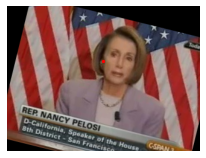

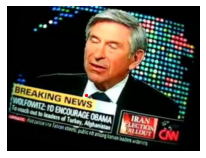

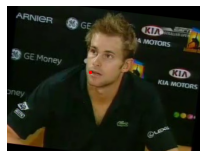

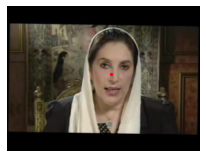

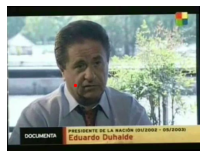

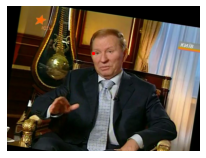

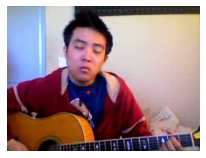

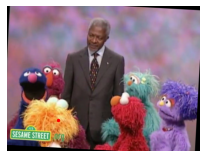

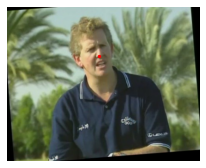

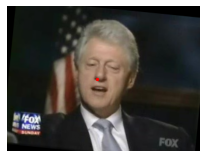

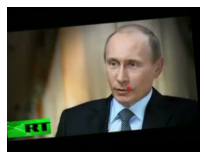

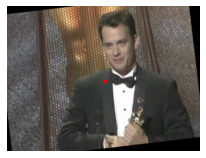

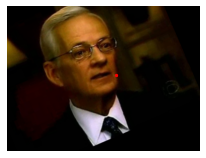

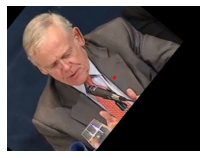

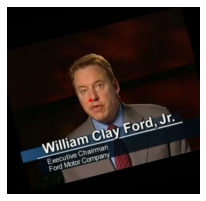

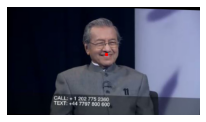

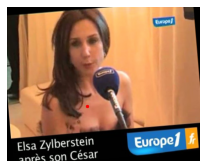

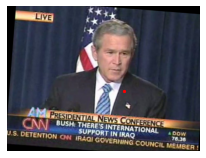

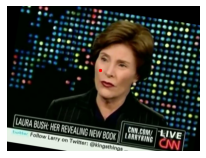

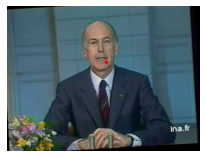

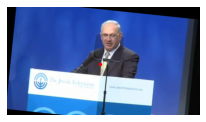

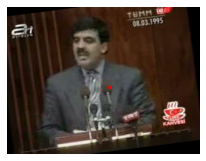

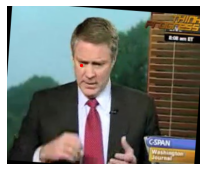

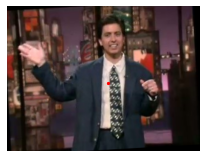

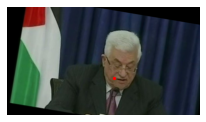

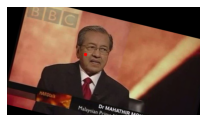

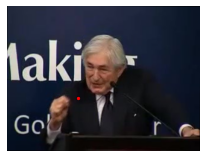

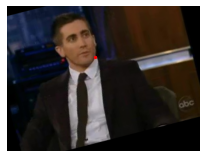

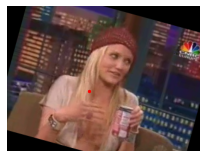

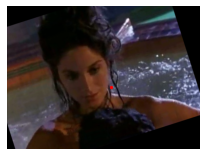

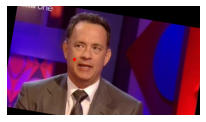

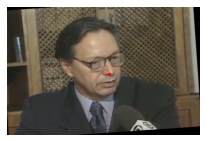

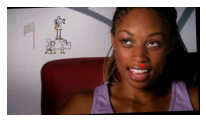

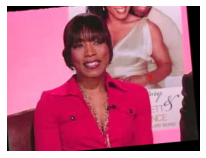

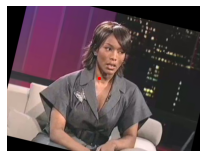

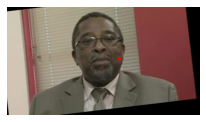

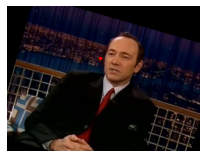

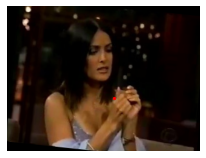

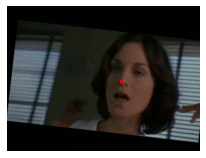

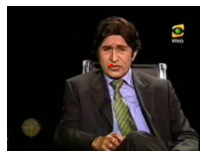

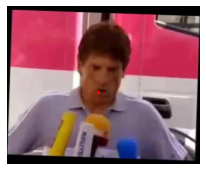

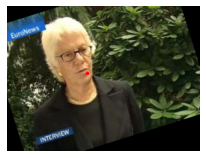

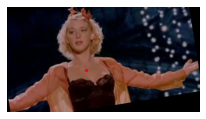

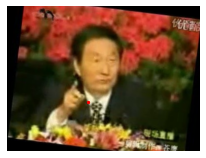

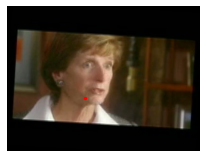

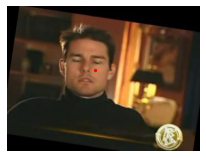

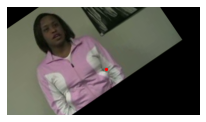

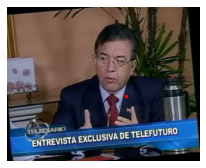

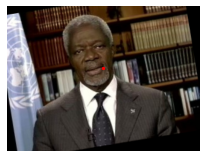

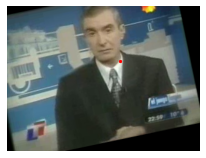

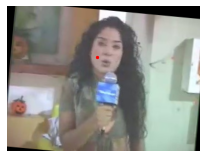

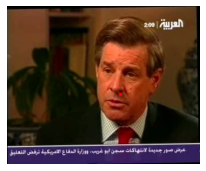

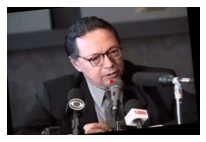

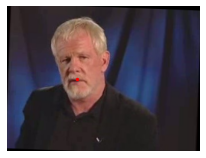

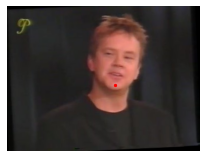

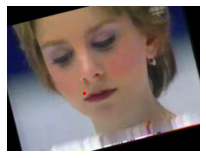

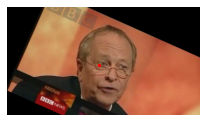

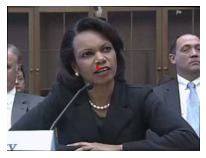

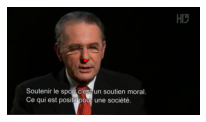

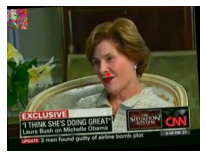

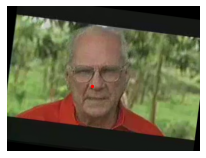

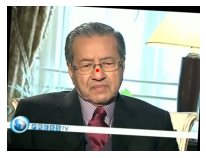

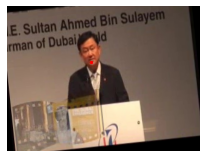

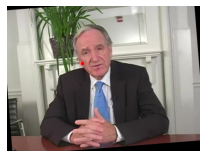

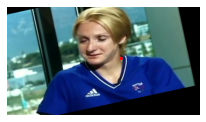

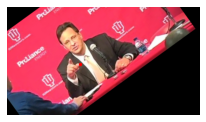

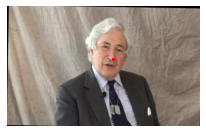

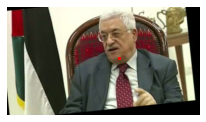

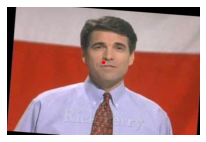

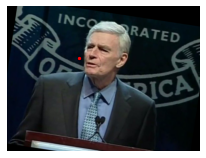

In [672]:
preprocess_imgs(test_video_images, fcnn_model, facial_keypoints_regressor)

#### Visualization of preprocessing

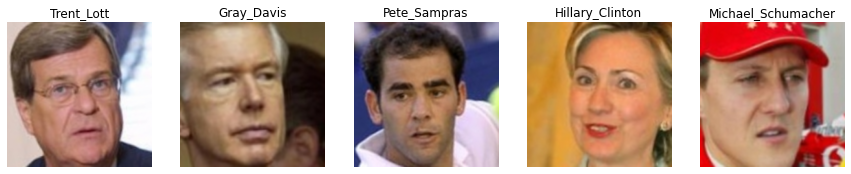

In [634]:
visualize(x_train, y_train, function = lambda x:preprocess_imgs(x, fcnn_model, facial_keypoints_regressor)[0])

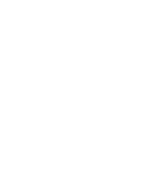

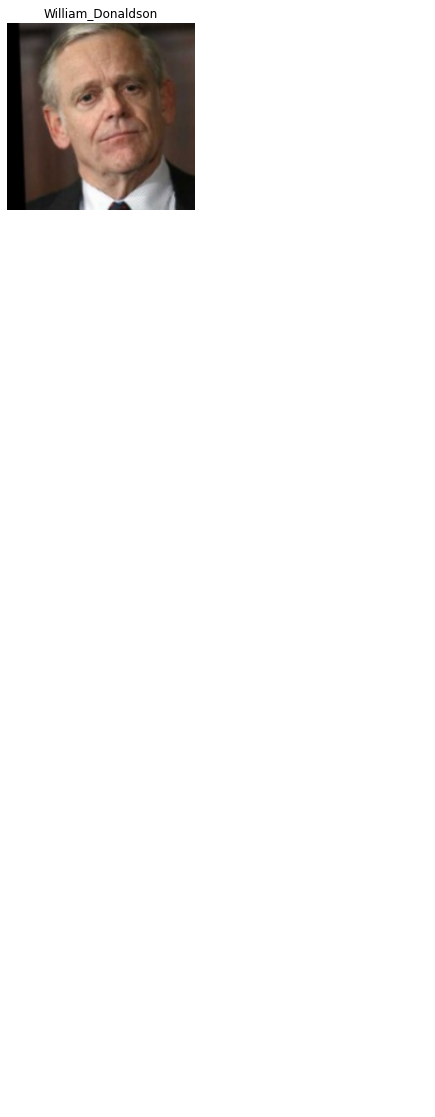

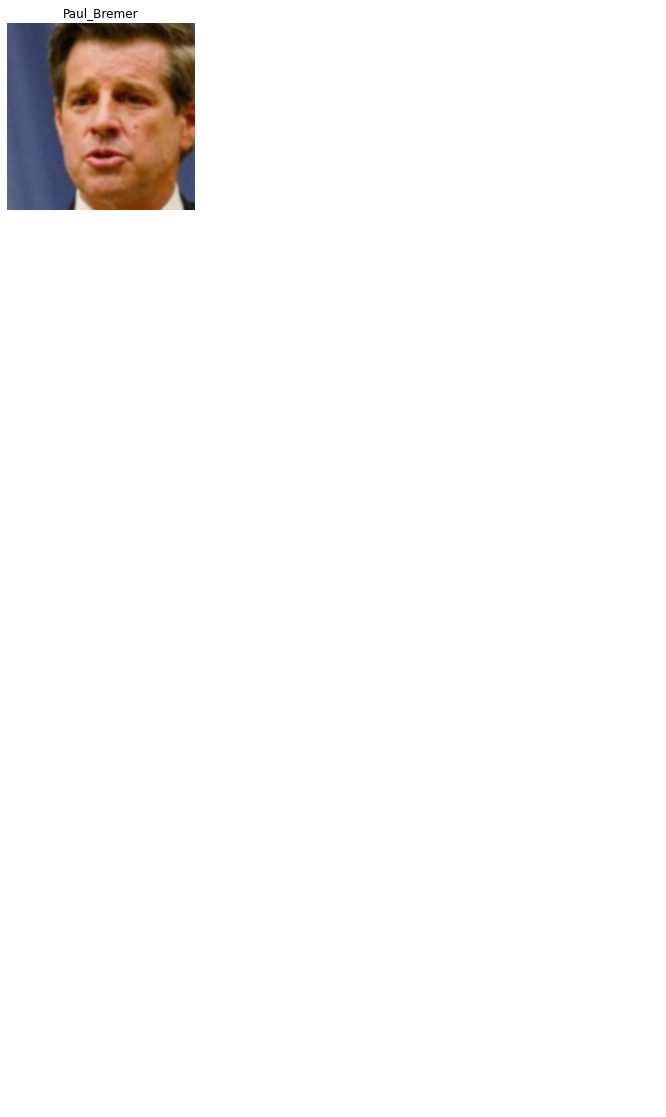

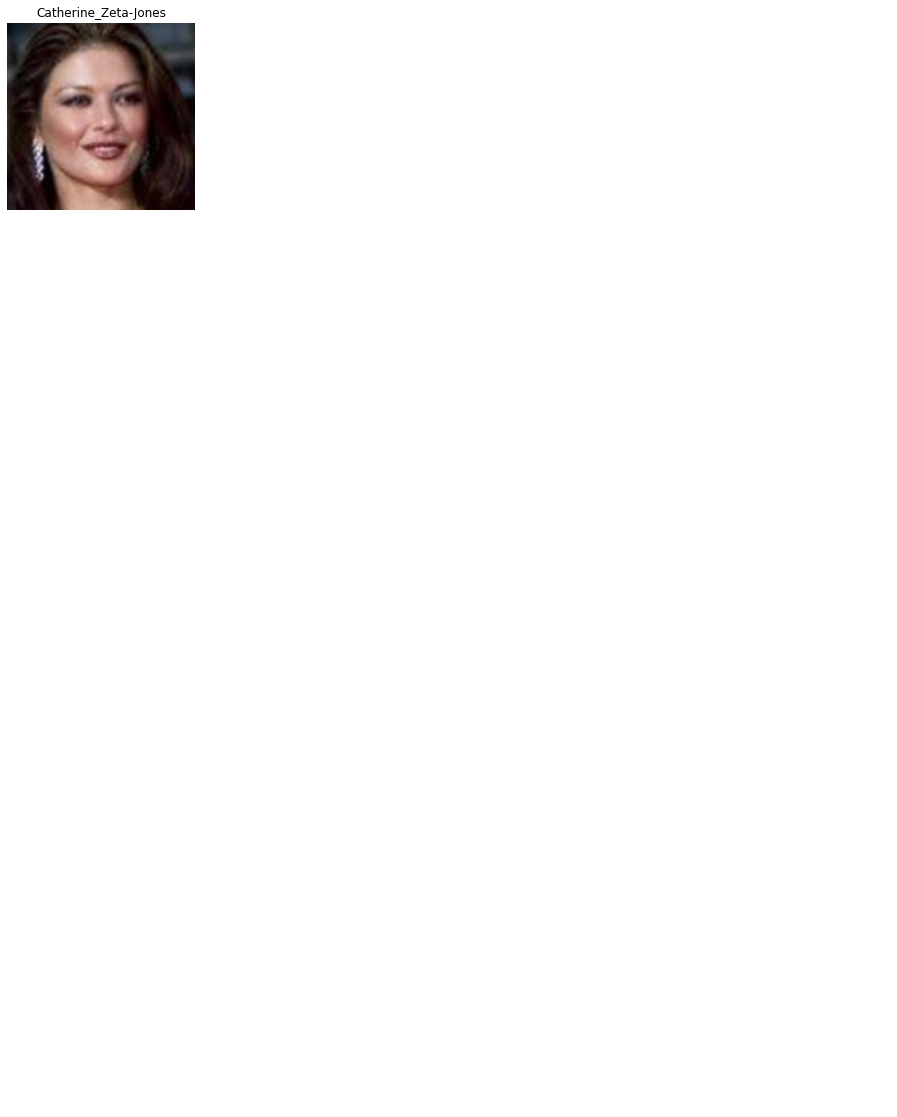

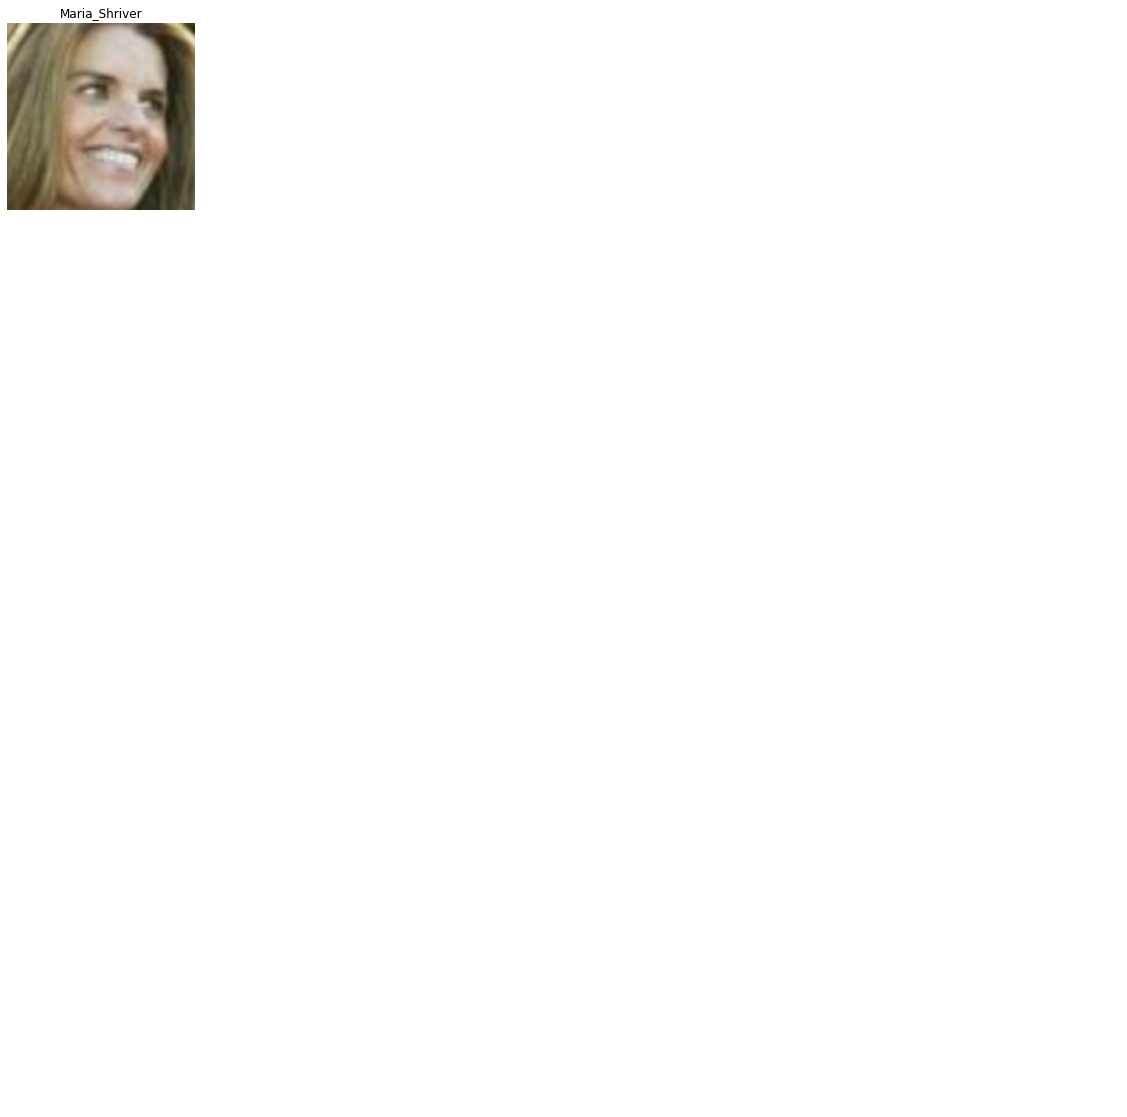

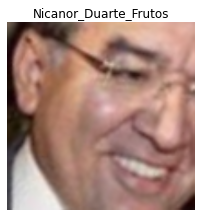

In [647]:
visualize(video_train, train_labels, function = lambda x:preprocess_imgs(x, fcnn_model, facial_keypoints_regressor)[0])

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [548]:
model = load_model('face_recognition_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [549]:
def get_layer_output(images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [550]:
img = cv2.resize(x_train['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print(out.shape)

(1, 4096)


### Training classifier (2 points)


You have to implement class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

In [607]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from skimage.io import imread
import cv2
from os.path import join
class Classifier():
    def __init__(self, nn_model, fcnn_model, facial_keypoints_regressor, feature_layer = 'fc6'):
        self.feature_layer = feature_layer
        self.feature_extraction_model = self.__build_feature_extractor(nn_model)
        self.fcnn_model = fcnn_model
        self.facial_keypoints_regressor = facial_keypoints_regressor

    def fit(self, train_imgs, train_labels):
        images = []
        labels = []
        for key in train_imgs:
            images.append( train_imgs[key] )
            labels.append( train_labels[key] )
        
        image_embeddings = self.__get_embeddings(images)
        self.nbrs = kNN(n_neighbors=1, metric="cosine")
        self.nbrs.fit(image_embeddings, labels)

    def classify_images(self, test_imgs):
        images = []
        keys = []
        for key in test_imgs:
            images.append( test_imgs[key] )
            keys.append(key)
            
        image_embeddings = self.__get_embeddings(images)
        predicted = self.nbrs.predict(image_embeddings)
        
        result = { keys[i] : label for i, label in enumerate(predicted) }
        
        return result
        
    def classify_videos(self, test_video):
        """Your implementation"""
        pass
    
    def __build_feature_extractor(self, nn_model):        
        output = nn_model.get_layer(self.feature_layer).output
        return Model(nn_model.input, output)
    
    def __get_embeddings(self, images):        
        # without pre-precessing:
        #images = np.array([ transform.resize( img, (RECOGNITION_INPUT_SHAPE[0], RECOGNITION_INPUT_SHAPE[1]), anti_aliasing=True) for img in images ])
        # with pre-precessing:
        images = preprocess_imgs(images, self.fcnn_model, self.facial_keypoints_regressor)        
        image_embeddings = self.feature_extraction_model.predict(images)
        return image_embeddings

Now we can build the classifier, fit it and use to predict the labels of testing images.

In [587]:
img_classifier = Classifier(model, fcnn_model, facial_keypoints_regressor)
img_classifier.fit(x_train, y_train)
y_out = img_classifier.classify_images(x_test)

C:\Users\MachineLearningUser\AppData\Local\conda\conda\envs\ml\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\MachineLearningUser\AppData\Local\conda\conda\envs\ml\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\MachineLearningUser\AppData\Local\conda\conda\envs\ml\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Image classification quality (2 points)

Let us check the accuracy of your classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.90, to obtain 2 points — at least 0.95.

In [588]:
def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for k, v in gt.items():
        if output[k] == v:
            correct += 1
    accuracy = correct / total

    return 'Classification accuracy is %.4f' % accuracy

In [589]:
print( check_test(y_out, y_test) )

Classification accuracy is 0.9641


### Video classification quality (2 points)

Let us check the quality of video classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.80, to obtain 2 points — at least 0.85.

In [591]:
video_classifier = Classifier(model, fcnn_model, facial_keypoints_regressor)
video_classifier.fit(video_train, train_labels)

C:\Users\MachineLearningUser\AppData\Local\conda\conda\envs\ml\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\MachineLearningUser\AppData\Local\conda\conda\envs\ml\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\MachineLearningUser\AppData\Local\conda\conda\envs\ml\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [596]:
video_images_test = np.array([ video_test[key][0] for key in video_test ])

C:\Users\MachineLearningUser\AppData\Local\conda\conda\envs\ml\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [601]:
video_images_test[3].shape

(288, 384, 3)

In [608]:
#y_video_out = video_classifier.classify_videos( [ video_test[key][0] for key in video_test ] )
y_video_out = video_classifier.classify_images( { key : video_test[key][0] for key in video_test } )

C:\Users\MachineLearningUser\AppData\Local\conda\conda\envs\ml\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\MachineLearningUser\AppData\Local\conda\conda\envs\ml\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\MachineLearningUser\AppData\Local\conda\conda\envs\ml\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [609]:
print(check_test(y_video_out, test_labels))

Classification accuracy is 0.5143
